# Visualization

The resulting visualization will show two UMAP plots:
	•	Original cell types from ```celltype```. This is from the ground truth
	•	Predicted cell types from ```predictions```.

In [34]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [35]:
projectDir = Path(f"/tscc/nfs/home/s5srinivasan/scgpt-project/scGPT-ucsd-fork")
dataDir = Path(f"/tscc/nfs/home/s5srinivasan/scratch")

# Load .h5ad file
dataObj = sc.read_h5ad(dataDir / "predictionsWilk2.h5ad")
baliData = sc.read_h5ad(dataDir / "predictionsBali.h5ad")
leeData = sc.read_h5ad(dataDir / "predictionsLee.h5ad")
ssCombinedData = sc.read_h5ad(dataDir / "predictionsSS_combined.h5ad")
ssc1Data = sc.read_h5ad(dataDir / "predictionsSS_C1.h5ad")
ssc2Data = sc.read_h5ad(dataDir / "predictionsSS_C2.h5ad")

# Nearest neighbor graph constuction and visualization

1.	Compute PCA: UMAP requires a reduced representation of the data. ```sc.tl.pca``` computes principal components (default: 50 PCs).
2.	Compute Neighbors: ```sc.pp.neighbors``` calculates a neighborhood graph based on PCA-reduced data. This is required before running UMAP.
3.	Compute UMAP: ```sc.tl.umap``` generates UMAP embeddings using the neighbors graph.
4.	Sanity Checking Columns: Ensure the celltype and predictions columns exist before proceeding.



In [38]:
predictionObjs = {
    "Wilk": dataObj, 
    "Bali" : baliData,
    "Lee" : leeData,
    "SS Combined" : ssCombinedData,
    "SS_C1": ssc1Data, 
    "SS_C2": ssc2Data
}

for study,obj in predictionObjs.items():
    if 'X_umap' not in obj.obsm: # Check if UMAP embeddings are present - NOT PRESENT 
        if 'neighbors' not in obj.uns:  # Check if neighbors are already computed - NOT PRESENT
        
            # Compute neighbors using PCA (default)
            sc.tl.pca(obj)  # Compute PCA if not already done
            sc.pp.neighbors(obj)  # Compute neighbors
        
        # Compute UMAP
        sc.tl.umap(obj)

ValueError: too many values to unpack (expected 2)

In [ ]:
# Ensure the two columns exist in dataObj.obs
for study,obj in predictionObjs.items():
    if 'celltype' not in obj.obs or 'predictions' not in obj.obs:
        raise ValueError(f"The specified columns 'celltype' and 'predictions' do not exist in {study}.obs")

In [114]:
studyName = "SS Combined" # pass study name here to add to plot titles
dataObj = predictionObjs[studyName]

In [115]:
celltypes = dataObj.obs["celltype"].unique()
numtypes = len(celltypes)
predictions = dataObj.obs["predictions"].unique()
numpreds = len(predictions)

In [116]:
# Combine unique labels from both "celltype" and "predictions"
all_labels = sorted(list(set(celltypes.tolist() + predictions.tolist())))  # Merge, deduplicate, and sort

# Generate a color palette for all unique labels
palette_colors = sns.color_palette("tab20", len(all_labels))

# Create a dictionary mapping each label to a color
palette_ = {label: palette_colors[i] for i, label in enumerate(all_labels)}

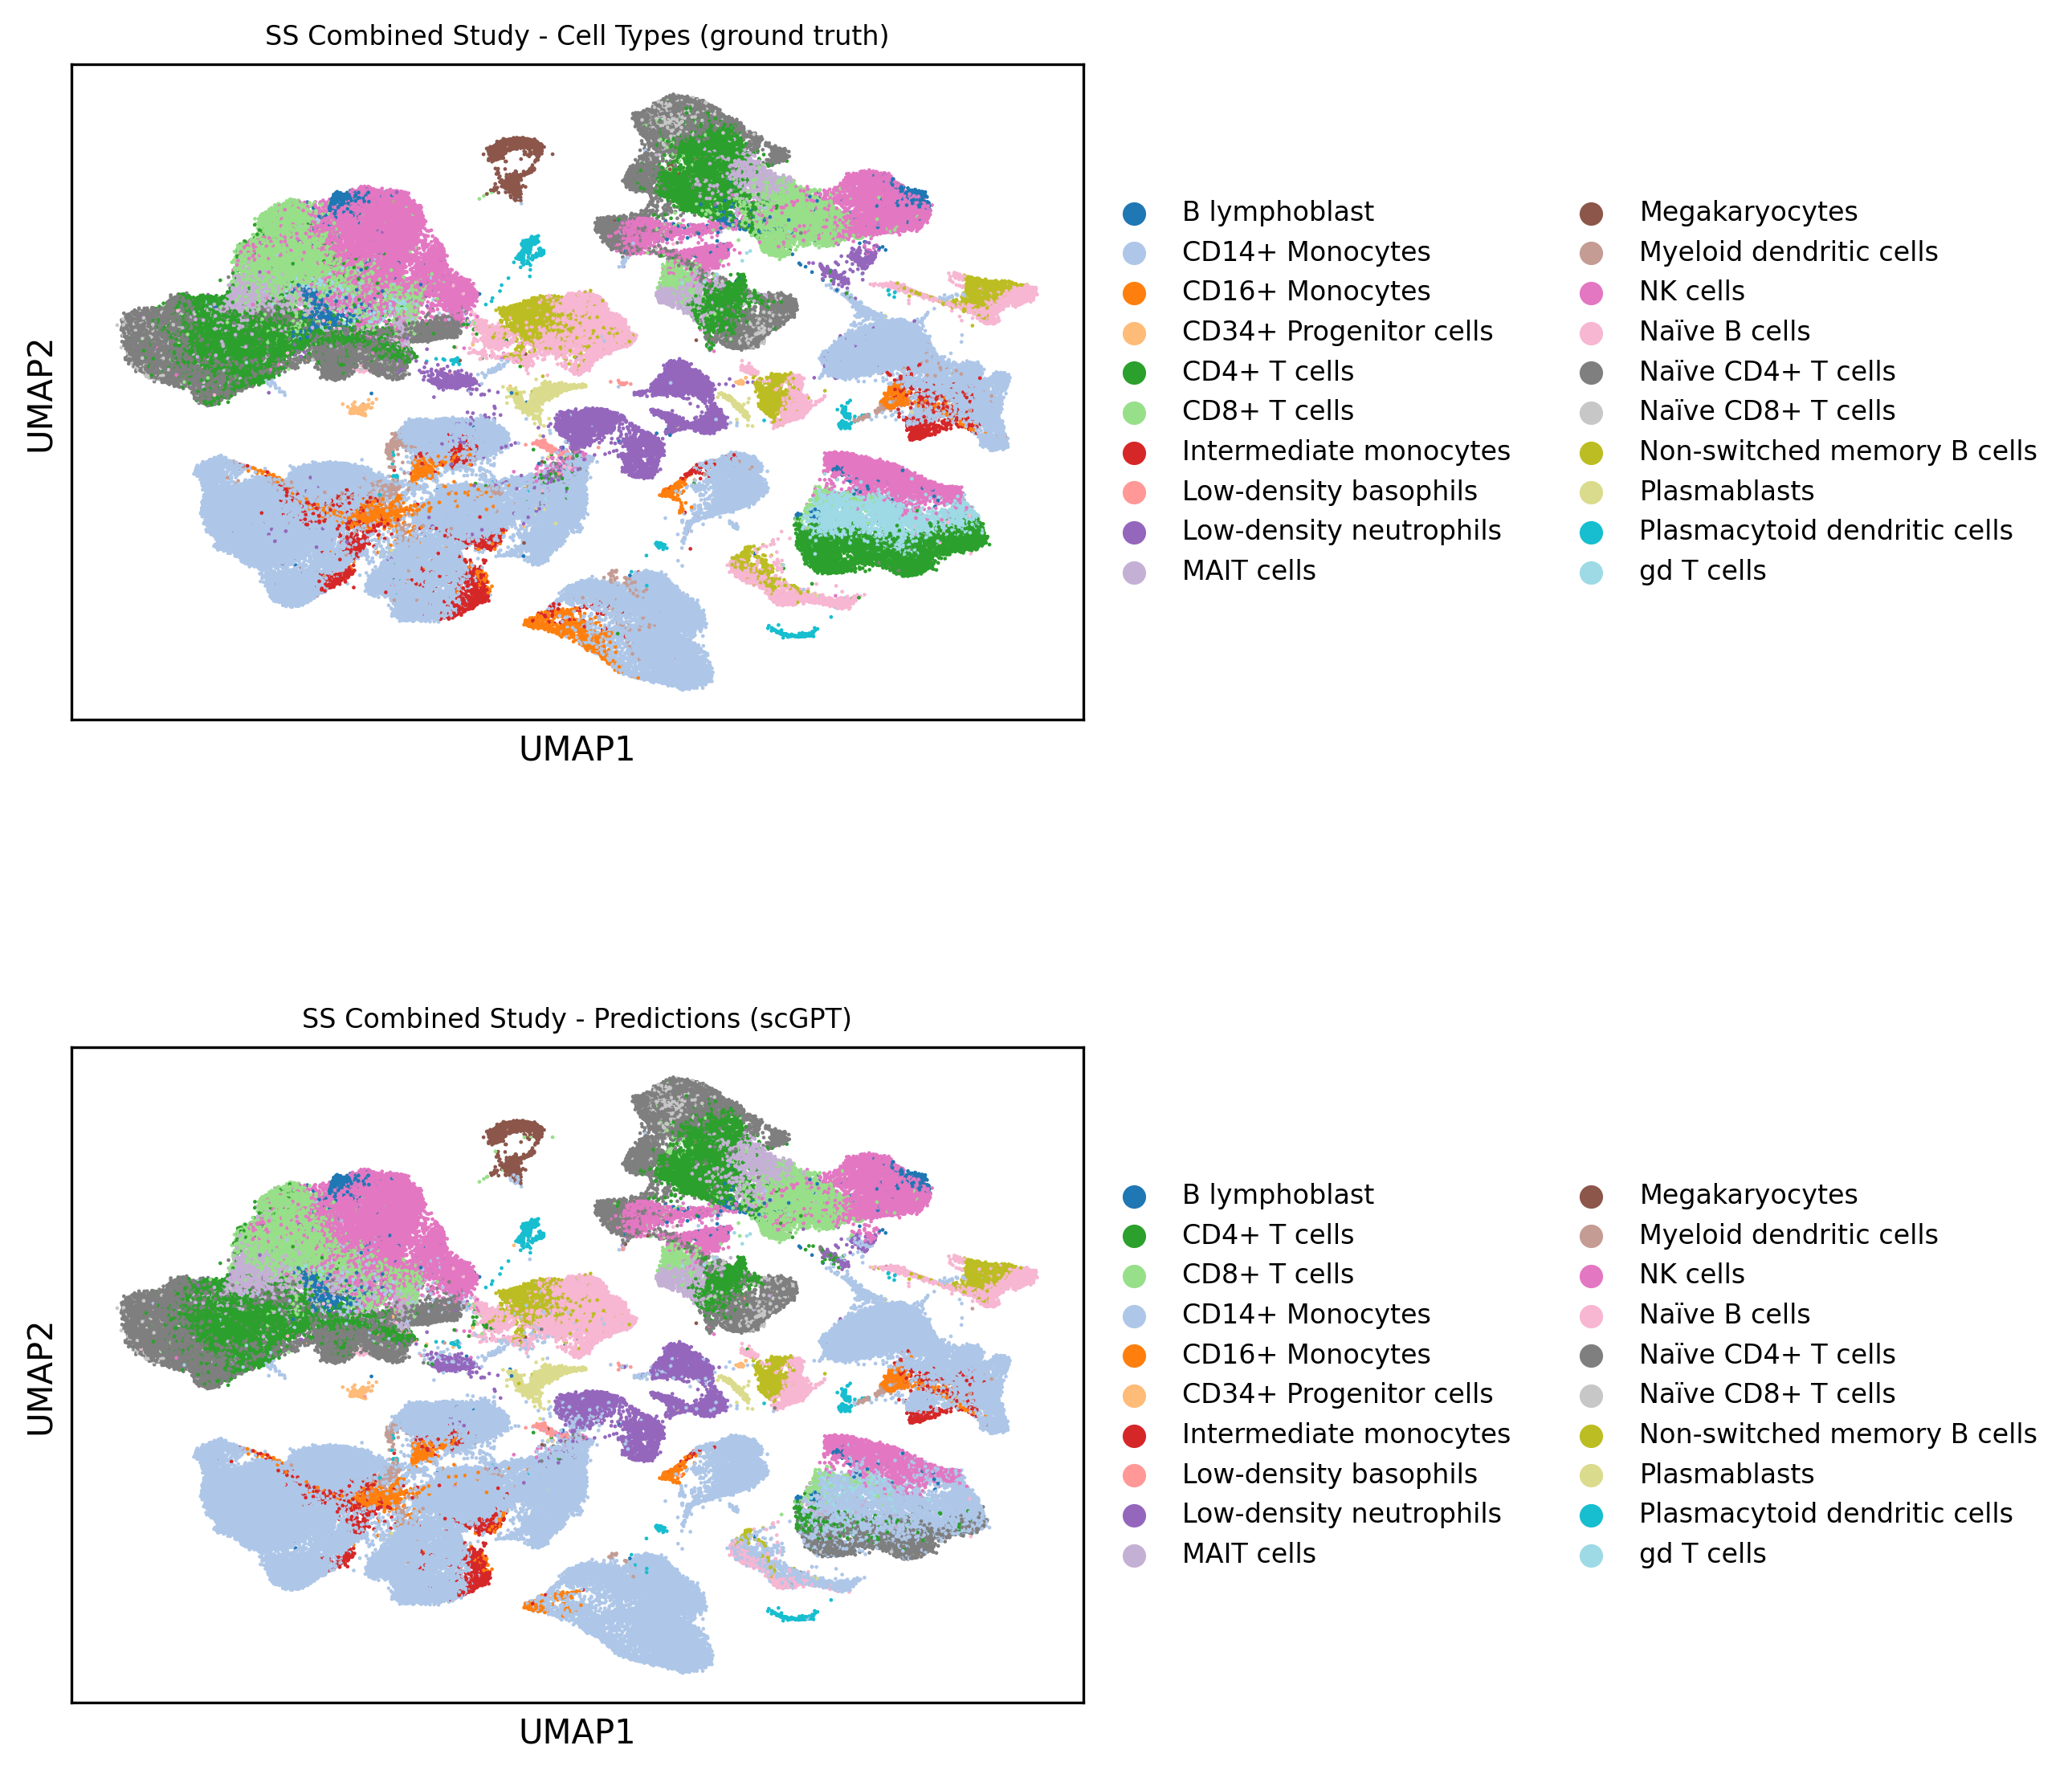

In [117]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 8), dpi=300)  # Increased size for better layout

# First UMAP plot
sc.pl.umap(
    dataObj,
    color="celltype",
    palette=palette_,
    ax=axes[0],  # Use the first subplot
    show=False,
    size=5,
    legend_fontsize=8,  # Decrease legend font size
)
axes[0].set_title(f"{studyName} Study - Cell Types (ground truth)", fontsize=8)  # Reduced text size
axes[0].tick_params(axis="both", which="major", labelsize=5)  # Smaller tick labels

# Second UMAP plot
sc.pl.umap(
    dataObj,
    color="predictions",
    palette=palette_,
    ax=axes[1],  # Use the second subplot
    show=False,
    size=5,
    legend_fontsize=8,  # Decrease legend font size
)
axes[1].set_title(f"{studyName} Study - Predictions (scGPT)", fontsize=8)  # Reduced text size
axes[1].tick_params(axis="both", which="major", labelsize=5)  # Smaller tick labels

# Adjust spacing
fig.subplots_adjust(top=0.95, bottom=0.1, left=0.15, right=0.85, hspace=0.5)  # Adjust margins and space between plots

plt.savefig("umap_comparison.png", dpi=300, bbox_inches="tight")

plt.show()
# Save the plot to a file


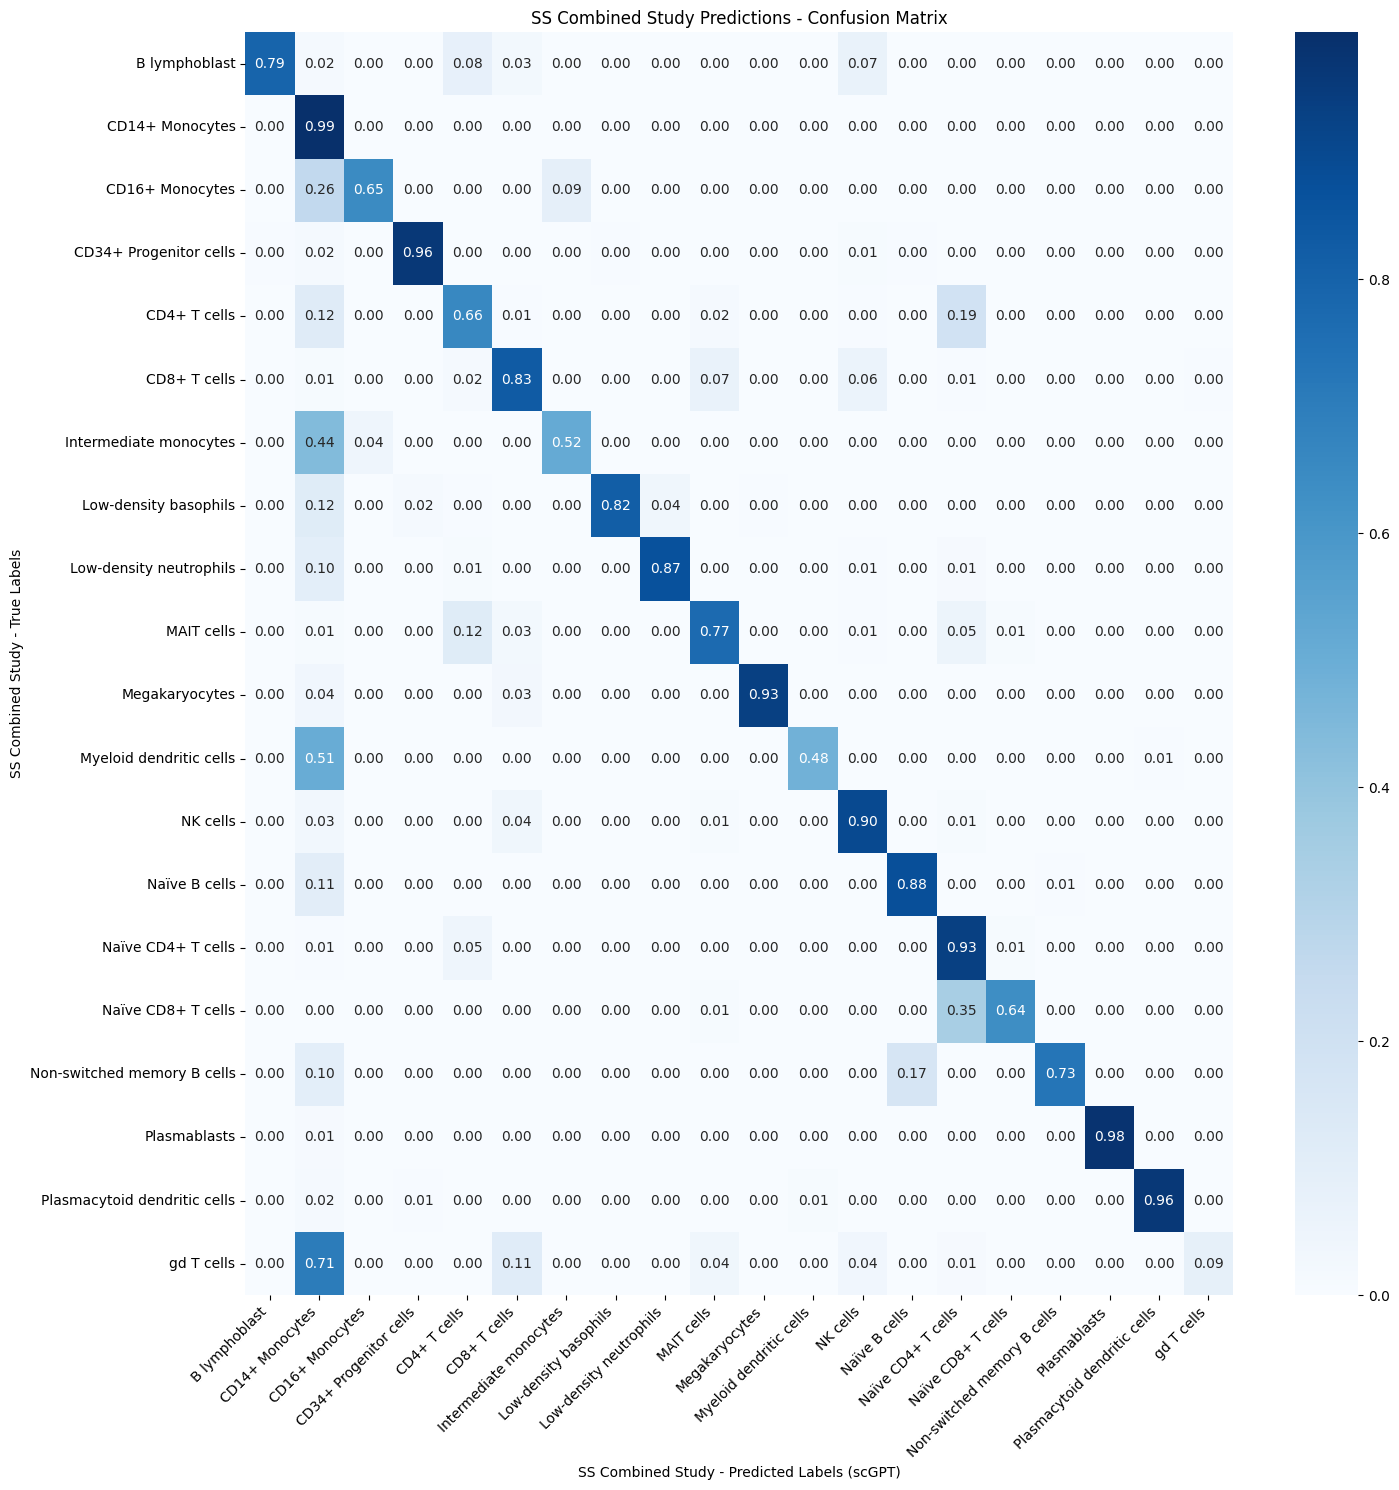

In [118]:
# Extract labels and predictions
labels = dataObj.obs["celltype"].astype(str).values  # Ensure these are strings
predictions = dataObj.obs["predictions"].astype(str).values

# Create a sorted list of unique cell types for consistent ordering
celltypes = sorted(list(set(labels) | set(predictions)))

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions, labels=celltypes)

# Normalize the confusion matrix row-wise
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# Convert the confusion matrix to a DataFrame for easy labeling
cm_df = pd.DataFrame(cm_normalized, index=celltypes, columns=celltypes)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title(f"{studyName} Study Predictions - Confusion Matrix")
plt.xlabel(f"{studyName} Study - Predicted Labels (scGPT)")
plt.ylabel(f"{studyName} Study - True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_196732/1487404912.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=axes[0], palette='Blues_d')
/tmp/ipykernel_196732/1487404912.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predictions_counts.index, y=predictions_counts.values, ax=axes[1], palette='Oranges_d')


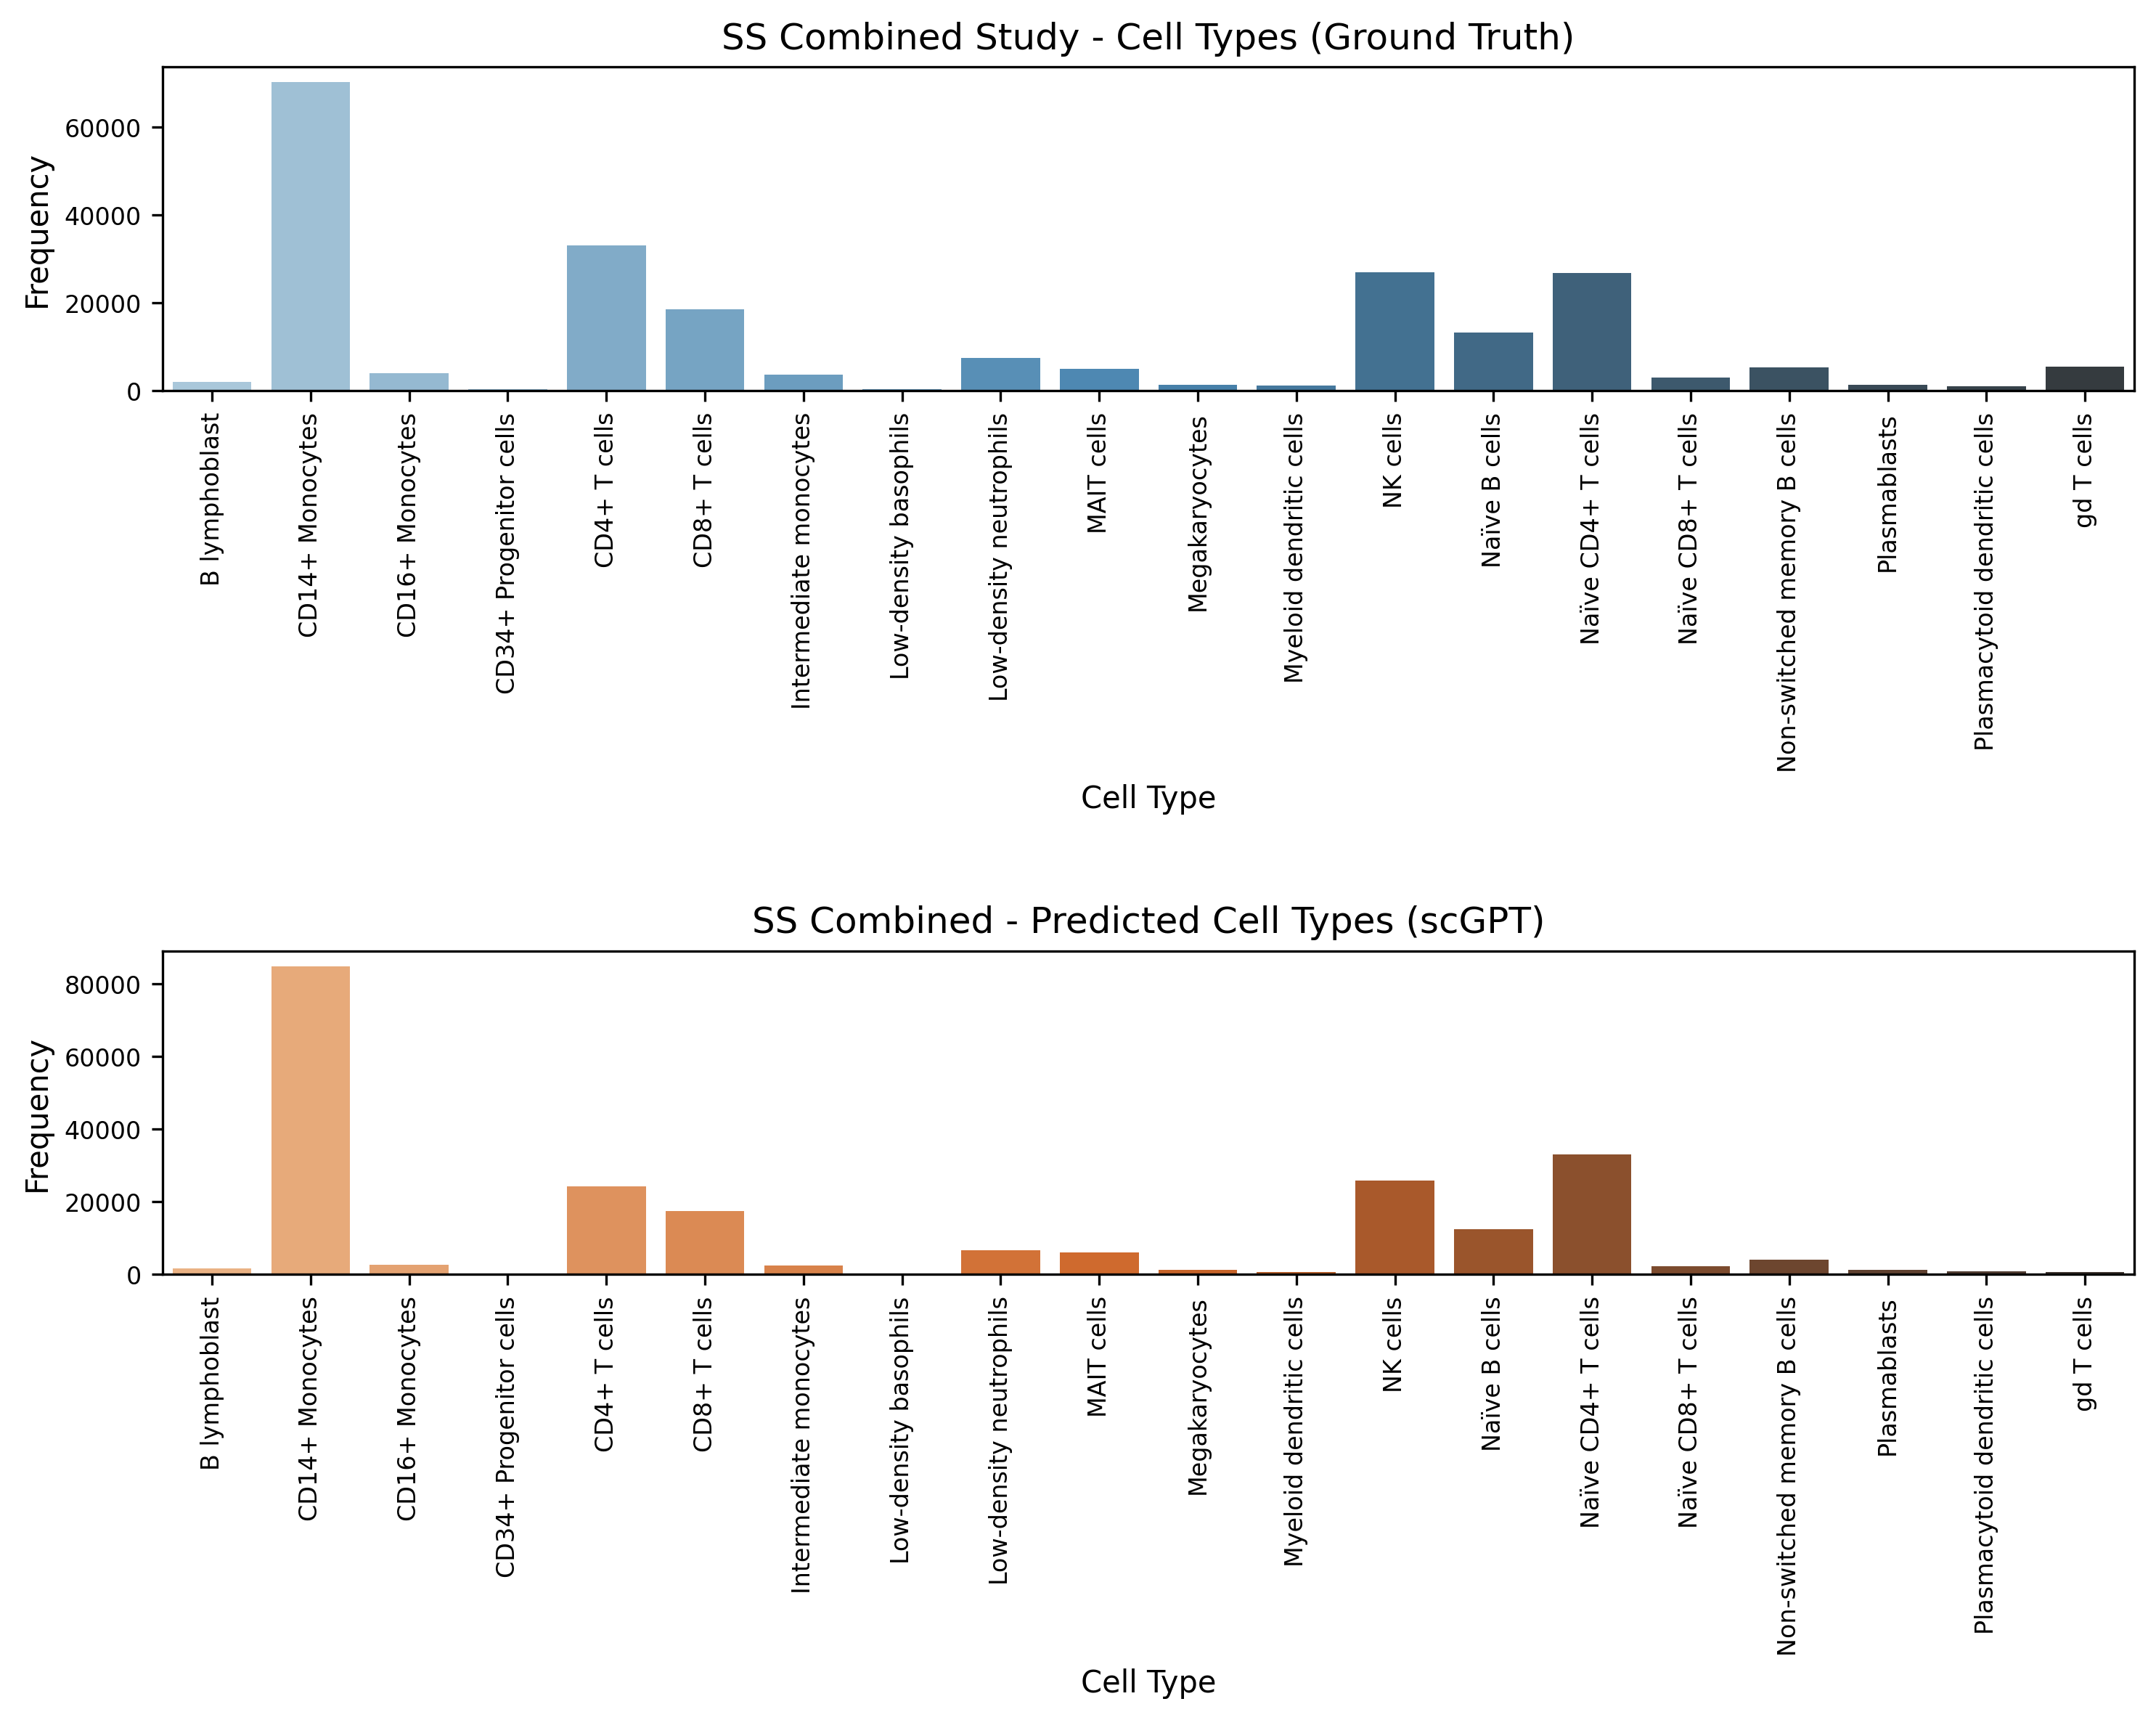

In [119]:
# Convert to DataFrames for easier plotting
labels_df = pd.DataFrame(labels, columns=['Cell Type'])
predictions_df = pd.DataFrame(predictions, columns=['Cell Type'])

# Count frequencies for ground truth and predictions
labels_counts = labels_df['Cell Type'].value_counts().sort_index()
predictions_counts = predictions_df['Cell Type'].value_counts().sort_index()

# Create a figure with two subplots (one below the other)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)

# Ground truth plot
sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=axes[0], palette='Blues_d')
axes[0].set_title(f"{studyName} Study - Cell Types (Ground Truth)", fontsize=12)
axes[0].set_xlabel("Cell Type", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)
axes[0].tick_params(axis='x', rotation=90, labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)

# Predictions plot
sns.barplot(x=predictions_counts.index, y=predictions_counts.values, ax=axes[1], palette='Oranges_d')
axes[1].set_title(f"{studyName} - Predicted Cell Types (scGPT)", fontsize=12)
axes[1].set_xlabel("Cell Type", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)
axes[1].tick_params(axis='x', rotation=90, labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)

# Adjust layout for better spacing between subplots
plt.tight_layout(h_pad=3)  # h_pad adjusts vertical spacing
plt.show()